In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utilities import Old_CNN_bw, Old_CNN_color
from tqdm.notebook import tqdm

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
#"../../../shenhao/sat_image_nhts/code/data_process/"

import pickle
with open('../census_id_to_index.pickle', 'rb') as handle:
    census_id_to_index = pickle.load(handle)

In [4]:
def training(x_id_train, y_train, x_id_test, y_test, optimizer, criterion, n_epochs = 100, batch_size = 200):
#More memory efficient?

    #training
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    validate_losses = []
    validate_accuracies = []

    validate_losses_running = []
    validate_accurate_running = []


    test_indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in x_id_test]
    x_test_images = image_array[test_indices,:,:,:]
    x_test_images_norm_torch = torch.as_tensor(x_test_images).float()/255.0
    
    
    y_train_torch = torch.as_tensor(y_train[:,0])
    y_test_torch = torch.as_tensor(y_test[:,0])
    print(y_train_torch.size())
    print(y_test_torch.size())
    
    print("Training started: ")

    for n_epoch in range(n_epoches):
        # create permutation for batch training
        # To-Do: add permutation for SGD...But it is slow.
        #permutation = torch.randperm(x_train_images_norm_torch.size()[0])
        print("epoch: ", n_epoch)
        for i in tqdm(range(0, x_id_train.shape[0], batch_size)):
            # clear gradients first (for each iteration!)!
            optim.zero_grad()
            # forward pass

            #Get the indices in the image array of this batch
            ids = x_id_train[i:i+batch_size]
            indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

            #convert to torch and normalize
            to_torch = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0

            batch_x, batch_y = to_torch.to(device), y_train_torch[i:i+batch_size].to(device)

            batch_y_pred_train = cnn_net(batch_x)
            # loss 
            loss = criterion(batch_y_pred_train.squeeze(), batch_y)
            # compute gradients
            loss.backward()
            # one step optim
            optim.step()

        # eval training accuracy
        with torch.no_grad():
            # evaluate training loss/accuracy in batches


            train_losses_running = []
            train_accurate_running = []

            validate_losses_running = []
            validate_accurate_running = []


            for i in range(0, x_id_train.shape[0], batch_size):

                # load batch data
                ids = x_id_train[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

                batch_image_train_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_train = y_train_torch[i:i+batch_size].to(device)
                y_batch_probs_train = cnn_net(batch_image_train_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_train.size()[0]
                loss_train = criterion(y_batch_probs_train.squeeze(), batch_y_train)
                train_losses_running.append(loss_train.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_train = torch.max(y_batch_probs_train, axis = 1)
                accurate_pred_train = (batch_predict_train == batch_y_train).sum().item()
                train_accurate_running.append(accurate_pred_train)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            train_losses.append(sum(train_losses_running) / x_id_train.shape[0]) # average loss per epoch
            train_accuracies.append(sum(train_accurate_running) / x_id_train.shape[0]) # average accuracy per epoch


            # evaluate validation accuracy/loss in batches
            for i in range(0, x_id_test.shape[0], batch_size):

                # load batch data

                ids = x_id_test[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]


                batch_image_val_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_val = y_test_torch[i:i+batch_size].to(device)
                y_batch_probs_val = cnn_net(batch_image_val_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_val.size()[0]
                loss_validate = criterion(y_batch_probs_val.squeeze(), batch_y_val)
                validate_losses_running.append(loss_validate.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_val = torch.max(y_batch_probs_val, axis = 1)
                accurate_pred_val = (batch_predict_val == batch_y_val).sum().item()
                validate_accurate_running.append(accurate_pred_val)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            validate_losses.append(sum(validate_losses_running) / x_id_test.shape[0]) # average loss per epoch
            validate_accuracies.append(sum(validate_accurate_running) / x_id_test.shape[0]) # average accuracy per epoch


            # print performance updates
            if n_epoch % 5 == 0:
                print("Printing accuracies")
                #_, preds = torch.max(cnn_net(x_test_images_norm_torch.to(device)), axis=1)
                #unique = preds.unique(sorted=True)
                print('Epoch {}: train loss: {}'.format(n_epoch, train_losses[-1]))
                print('Epoch {}: train accuracy: {}'.format(n_epoch, train_accuracies[-1]))
                #print('Epoch {}: prediction counts: {}'.format(n_epoch, [(i.item(), (preds==i).sum().item()) for i in unique] ))
                print('Epoch {}: validate loss: {}'.format(n_epoch, validate_losses[-1]))
                print('Epoch {}: validate accuracy: {}'.format(n_epoch, validate_accuracies[-1]))

    return train_losses, validate_losses, train_accuracies, validate_accuracies
   



In [5]:
train_unique = pd.read_csv("../train_unique.csv")
test_unique = pd.read_csv("../test_unique.csv")

In [6]:
train_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,40900,37183053422,53422,183,1,0,1,0,1,1,...,C,5,234.0,5,509,2,1,3,5,52
1,351773,36005019300,19300,5,1,1,1,0,0,0,...,U,90,237.2,3,1200,0,0,1,2,21
2,347555,17141961300,961300,141,1,0,1,0,0,0,...,R,5,217.4,5,1200,2,1,2,3,34
3,145315,40109107211,107211,109,1,0,0,0,0,1,...,C,30,224.2,3,1700,2,1,3,7,72
4,248640,37067002702,2702,67,1,0,0,0,0,1,...,C,80,240.8,3,900,1,1,3,5,53


In [7]:
test_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,5281,36055012500,12500,55,1,1,0,0,0,1,...,S,5,244.7,5,755,1,1,1,2,22
1,615389,50007000100,100,7,1,0,1,0,0,1,...,S,30,248.0,5,650,1,1,1,1,13
2,291709,34025810502,810502,25,1,0,0,0,0,1,...,T,0,232.6,5,610,2,1,1,2,21
3,125237,37183053424,53424,183,1,1,0,0,0,1,...,C,20,222.7,4,810,1,1,3,5,52
4,252390,35043010722,10722,43,1,0,0,0,1,1,...,S,5,218.0,5,1751,2,1,4,8,83


In [8]:
x_id_train = train_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_train.shape)
print(x_id_train)
x_id_test = test_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_test.shape)
print(x_id_test)
y_train = train_unique["TRPTRANS"].values.reshape(-1,1)
print(y_train.shape)
y_test = test_unique["TRPTRANS"].values.reshape(-1,1)
print(y_test.shape)

(27234, 1)
[[37183053422]
 [36005019300]
 [17141961300]
 ...
 [ 6053012800]
 [13139000303]
 [36033951200]]
(5447, 1)
[[36055012500]
 [50007000100]
 [34025810502]
 ...
 [ 4013093104]
 [ 6037460600]
 [ 6073015405]]
(27234, 1)
(5447, 1)


In [9]:
print(np.unique(y_train))
print(np.unique(y_test))
classes = len(np.unique(y_train,return_counts = True)[0])
print(classes)
classes = 7

[1 2 3 4 5 6]
[1 2 3 4 5 6]
6


In [10]:
print(np.unique(y_test, return_counts=True)[1]/sum(np.unique(y_test, return_counts=True)[1]))

[0.06700936 0.47622545 0.23664402 0.16504498 0.03653387 0.01854232]


# Old CNN bw

In [14]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [15]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.06700936, 0.47622545, 0.23664402, 0.16504498, 0.03653387,
       0.01854232])

In [16]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [17]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [18]:
image_array.shape

(32681, 4, 224, 224)

In [19]:
cnn_net = Old_CNN_bw(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [20]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.5635534796830692
Epoch 0: train accuracy: 0.4708085481383565
Epoch 0: validate loss: 1.5732391848790879
Epoch 0: validate accuracy: 0.47622544519919224
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.5108329483597274
Epoch 5: train accuracy: 0.4764632444738195
Epoch 5: validate loss: 1.5978795994043744
Epoch 5: validate accuracy: 0.4734716357628052
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.4421274120905523
Epoch 10: train accuracy: 0.5081882940442094
Epoch 10: validate loss: 1.6706928486821409
Epoch 10: validate accuracy: 0.4404259225261612
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.4262760921118849
Epoch 15: train accuracy: 0.5136961151501799
Epoch 15: validate loss: 1.6995146714680256
Epoch 15: validate accuracy: 0.43253166880851845
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.4251503930127225
Epoch 20: train accuracy: 0.5148711169861203
Epoch 20: validate loss: 1.737615828144675
Epoch 20: validate accuracy: 0.40187259041674317
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.3946557807363829
Epoch 25: train accuracy: 0.5402070940735845
Epoch 25: validate loss: 1.941951632018218
Epoch 25: validate accuracy: 0.38369744813658896
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.6408122241203766
Epoch 30: train accuracy: 0.5046265697290152
Epoch 30: validate loss: 2.2868358304528154
Epoch 30: validate accuracy: 0.39306040022030475
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.4140576754992882
Epoch 35: train accuracy: 0.5324961445252259
Epoch 35: validate loss: 2.0933509966375983
Epoch 35: validate accuracy: 0.3785570038553332
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.3965684911827776
Epoch 40: train accuracy: 0.5342586472791364
Epoch 40: validate loss: 2.071892732564563
Epoch 40: validate accuracy: 0.3926932256287865
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.4011468086122214
Epoch 45: train accuracy: 0.5340383344348976
Epoch 45: validate loss: 2.1347769682880537
Epoch 45: validate accuracy: 0.3774554800807784
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.4194240627979018
Epoch 50: train accuracy: 0.5269883234192554
Epoch 50: validate loss: 2.1827456205946514
Epoch 50: validate accuracy: 0.37617036901046447
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.4478191418944366
Epoch 55: train accuracy: 0.5145039289123889
Epoch 55: validate loss: 2.1030057050425874
Epoch 55: validate accuracy: 0.390673765375436
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.518170620784576
Epoch 60: train accuracy: 0.484945288977014
Epoch 60: validate loss: 1.7291464565083459
Epoch 60: validate accuracy: 0.42537176427391227
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.4619710028648656
Epoch 65: train accuracy: 0.5239773812146582
Epoch 65: validate loss: 2.1337258239087435
Epoch 65: validate accuracy: 0.37323297227831836
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.5736450506410489
Epoch 70: train accuracy: 0.5197547183667475
Epoch 70: validate loss: 2.642008125180167
Epoch 70: validate accuracy: 0.3392693225628787
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.5639069978164981
Epoch 75: train accuracy: 0.5087757949621796
Epoch 75: validate loss: 2.4370565017429167
Epoch 75: validate accuracy: 0.3530383697448137
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.5477996238564713
Epoch 80: train accuracy: 0.514540647719762
Epoch 80: validate loss: 2.3479422329543205
Epoch 80: validate accuracy: 0.36864328988434003
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.544309881024663
Epoch 85: train accuracy: 0.477674965117133
Epoch 85: validate loss: 1.659370351914465
Epoch 85: validate accuracy: 0.4540113824123371
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.5045691347598433
Epoch 90: train accuracy: 0.48832341925534256
Epoch 90: validate loss: 1.6846383611762417
Epoch 90: validate accuracy: 0.4554800807784101
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.512206162756442
Epoch 95: train accuracy: 0.4853859146654917
Epoch 95: validate loss: 1.757932210047354
Epoch 95: validate accuracy: 0.4393243987516064
epoch:  96



epoch:  97



epoch:  98



epoch:  99


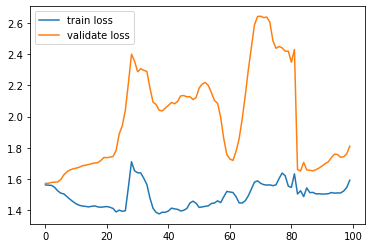

In [21]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

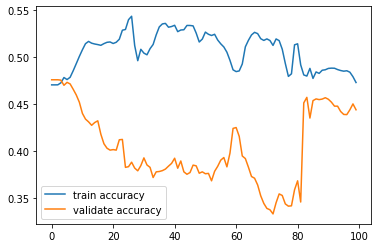

In [22]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Old CNN Color

In [11]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.06700936, 0.47622545, 0.23664402, 0.16504498, 0.03653387,
       0.01854232])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 3, 224, 224)

In [16]:
cnn_net = Old_CNN_color(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [17]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 2.5951598330182093
Epoch 0: train accuracy: 0.4708085481383565
Epoch 0: validate loss: 2.5908320130438725
Epoch 0: validate accuracy: 0.47622544519919224
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 2.5941070586195636
Epoch 5: train accuracy: 0.4708085481383565
Epoch 5: validate loss: 2.5889501563776562
Epoch 5: validate accuracy: 0.47622544519919224
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 2.590592861700804
Epoch 10: train accuracy: 0.4708085481383565
Epoch 10: validate loss: 2.5851864122307058
Epoch 10: validate accuracy: 0.47622544519919224
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 2.5900505254243607
Epoch 15: train accuracy: 0.4708085481383565
Epoch 15: validate loss: 2.5847023753741696
Epoch 15: validate accuracy: 0.47622544519919224
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 2.589370024819692
Epoch 20: train accuracy: 0.4708085481383565
Epoch 20: validate loss: 2.584143527302148
Epoch 20: validate accuracy: 0.47622544519919224
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 2.5885213815825376
Epoch 25: train accuracy: 0.4708085481383565
Epoch 25: validate loss: 2.5834616736269704
Epoch 25: validate accuracy: 0.47622544519919224
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 2.5876293537103194
Epoch 30: train accuracy: 0.4708085481383565
Epoch 30: validate loss: 2.5827761475090503
Epoch 30: validate accuracy: 0.47622544519919224
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 2.586944019250813
Epoch 35: train accuracy: 0.4708085481383565
Epoch 35: validate loss: 2.582355936142158
Epoch 35: validate accuracy: 0.47622544519919224
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 2.58851388910754
Epoch 40: train accuracy: 0.4708085481383565
Epoch 40: validate loss: 2.584299606293828
Epoch 40: validate accuracy: 0.47622544519919224
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 2.6002140624360157
Epoch 45: train accuracy: 0.4708085481383565
Epoch 45: validate loss: 2.596089242203686
Epoch 45: validate accuracy: 0.47622544519919224
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 2.6004576777592447
Epoch 50: train accuracy: 0.4708085481383565
Epoch 50: validate loss: 2.596009897621089
Epoch 50: validate accuracy: 0.47622544519919224
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 2.597263745487003
Epoch 55: train accuracy: 0.4708085481383565
Epoch 55: validate loss: 2.592578706291371
Epoch 55: validate accuracy: 0.47622544519919224
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.595686220970414
Epoch 60: train accuracy: 0.4708085481383565
Epoch 60: validate loss: 2.5906788077686214
Epoch 60: validate accuracy: 0.47622544519919224
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 2.597074504657456
Epoch 65: train accuracy: 0.4708085481383565
Epoch 65: validate loss: 2.5922531255652363
Epoch 65: validate accuracy: 0.47622544519919224
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 2.60374351810882
Epoch 70: train accuracy: 0.4708085481383565
Epoch 70: validate loss: 2.5999188078244235
Epoch 70: validate accuracy: 0.47622544519919224
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 2.588271550620242
Epoch 75: train accuracy: 0.4708085481383565
Epoch 75: validate loss: 2.583715991972126
Epoch 75: validate accuracy: 0.47622544519919224
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 2.4475195480004066
Epoch 80: train accuracy: 0.4708085481383565
Epoch 80: validate loss: 2.458862734602551
Epoch 80: validate accuracy: 0.47622544519919224
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 2.4475049903198967
Epoch 85: train accuracy: 0.4708085481383565
Epoch 85: validate loss: 2.4588772092846876
Epoch 85: validate accuracy: 0.47622544519919224
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 2.4474964416034948
Epoch 90: train accuracy: 0.4708085481383565
Epoch 90: validate loss: 2.4588665550337683
Epoch 90: validate accuracy: 0.47622544519919224
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 2.4474914340604514
Epoch 95: train accuracy: 0.4708085481383565
Epoch 95: validate loss: 2.458856560231043
Epoch 95: validate accuracy: 0.47622544519919224
epoch:  96



epoch:  97



epoch:  98



epoch:  99


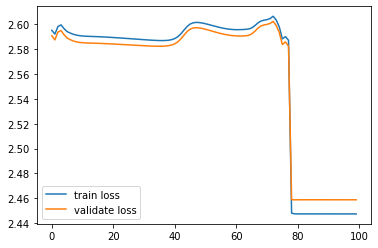

In [18]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

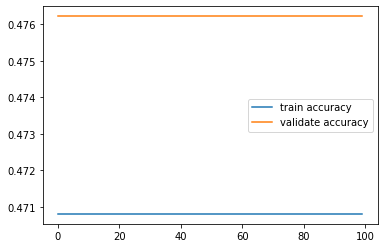

In [19]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 Color

In [11]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.06700936, 0.47622545, 0.23664402, 0.16504498, 0.03653387,
       0.01854232])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 3, 224, 224)

In [16]:
from torchvision import models

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes)
print(list(model_ft.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [17]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [18]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.3953783227771077
Epoch 0: train accuracy: 0.47073511052361017
Epoch 0: validate loss: 1.3970172952813404
Epoch 0: validate accuracy: 0.47622544519919224
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.3735290158816595
Epoch 5: train accuracy: 0.4708085481383565
Epoch 5: validate loss: 1.3706261165999525
Epoch 5: validate accuracy: 0.47622544519919224
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.3717854851500495
Epoch 10: train accuracy: 0.4708452669457296
Epoch 10: validate loss: 1.369887618749803
Epoch 10: validate accuracy: 0.4754910960161557
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.3713316392853037
Epoch 15: train accuracy: 0.47058823529411764
Epoch 15: validate loss: 1.3688326803767312
Epoch 15: validate accuracy: 0.4754910960161557
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.3702485000561047
Epoch 20: train accuracy: 0.47073511052361017
Epoch 20: validate loss: 1.369396048268857
Epoch 20: validate accuracy: 0.4756746833119148
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.3684323297650347
Epoch 25: train accuracy: 0.47091870456047585
Epoch 25: validate loss: 1.3710100636999607
Epoch 25: validate accuracy: 0.4756746833119148
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.364720240636939
Epoch 30: train accuracy: 0.4708085481383565
Epoch 30: validate loss: 1.3720581721708012
Epoch 30: validate accuracy: 0.47512392142463744
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.3635267388797012
Epoch 35: train accuracy: 0.47187339355217744
Epoch 35: validate loss: 1.3803301083400357
Epoch 35: validate accuracy: 0.4754910960161557
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.3509313982996969
Epoch 40: train accuracy: 0.4699272967614012
Epoch 40: validate loss: 1.4134945793722624
Epoch 40: validate accuracy: 0.469065540664586
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.3802819848082495
Epoch 45: train accuracy: 0.45270617610340014
Epoch 45: validate loss: 1.6630353831754643
Epoch 45: validate accuracy: 0.3752524325316688
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.2801259207376003
Epoch 50: train accuracy: 0.4930234265991041
Epoch 50: validate loss: 1.7372056757482406
Epoch 50: validate accuracy: 0.37929135303836975
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.224097815687706
Epoch 55: train accuracy: 0.5312477050745392
Epoch 55: validate loss: 2.293879904045804
Epoch 55: validate accuracy: 0.3532219570405728
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.3448471526016257
Epoch 60: train accuracy: 0.565102445472571
Epoch 60: validate loss: 3.3630224495431316
Epoch 60: validate accuracy: 0.31136405360749037
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.1591535767564547
Epoch 65: train accuracy: 0.6569729015201586
Epoch 65: validate loss: 4.373043769605667
Epoch 65: validate accuracy: 0.31356710115659997
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.2436744577642658
Epoch 70: train accuracy: 0.7058089153264302
Epoch 70: validate loss: 5.548163463899974
Epoch 70: validate accuracy: 0.3172388470717826
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.9269168169914929
Epoch 75: train accuracy: 0.7754644929132701
Epoch 75: validate loss: 6.051030265009029
Epoch 75: validate accuracy: 0.31558656140995045
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.5432260602295957
Epoch 80: train accuracy: 0.8469927296761401
Epoch 80: validate loss: 6.276711077696253
Epoch 80: validate accuracy: 0.3267853864512576
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.4204543847079268
Epoch 85: train accuracy: 0.8769919952999926
Epoch 85: validate loss: 6.711495177995749
Epoch 85: validate accuracy: 0.32182852946576096
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.4433225797962282
Epoch 90: train accuracy: 0.8790482485128883
Epoch 90: validate loss: 6.578156925328876
Epoch 90: validate accuracy: 0.3330273545070681
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.42148934417809847
Epoch 95: train accuracy: 0.8842256003525005
Epoch 95: validate loss: 7.264937349080996
Epoch 95: validate accuracy: 0.32054341839544703
epoch:  96



epoch:  97



epoch:  98



epoch:  99


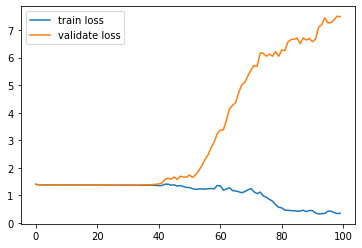

In [19]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

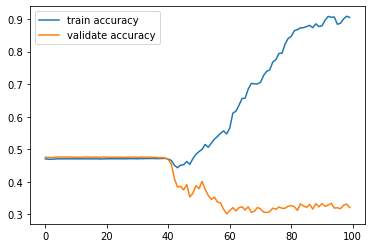

In [20]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 bw


In [11]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.06700936, 0.47622545, 0.23664402, 0.16504498, 0.03653387,
       0.01854232])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 4, 224, 224)

In [16]:
from torchvision import models
from torch.nn import Conv2d

model_ft = models.resnet18(pretrained=False)
for param in model_ft.parameters():
    param.requires_grad = True
model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes, bias = True)

In [17]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [18]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.411939852483001
Epoch 0: train accuracy: 0.465300727032386
Epoch 0: validate loss: 1.4054650695953803
Epoch 0: validate accuracy: 0.47200293739673216
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.3730130760804702
Epoch 5: train accuracy: 0.4708085481383565
Epoch 5: validate loss: 1.3706480681578872
Epoch 5: validate accuracy: 0.47622544519919224
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.369042669517787
Epoch 10: train accuracy: 0.4708085481383565
Epoch 10: validate loss: 1.3687542295464687
Epoch 10: validate accuracy: 0.47622544519919224
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.359110378541461
Epoch 15: train accuracy: 0.4708085481383565
Epoch 15: validate loss: 1.3708941243603971
Epoch 15: validate accuracy: 0.47622544519919224
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.3651556037653645
Epoch 20: train accuracy: 0.4708085481383565
Epoch 20: validate loss: 1.3694506762595446
Epoch 20: validate accuracy: 0.47622544519919224
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.3626582466786483
Epoch 25: train accuracy: 0.4708085481383565
Epoch 25: validate loss: 1.3766149498463465
Epoch 25: validate accuracy: 0.47622544519919224
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.3506598897273385
Epoch 30: train accuracy: 0.47187339355217744
Epoch 30: validate loss: 1.4577643711982309
Epoch 30: validate accuracy: 0.47053423903065905
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.606381918208806
Epoch 35: train accuracy: 0.47870309172358083
Epoch 35: validate loss: 2.7387204273088015
Epoch 35: validate accuracy: 0.3691940517716174
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.4447671575891015
Epoch 40: train accuracy: 0.5260703532349269
Epoch 40: validate loss: 3.386059621725473
Epoch 40: validate accuracy: 0.33816779878832387
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.248426690664841
Epoch 45: train accuracy: 0.590364984945289
Epoch 45: validate loss: 4.070534725987585
Epoch 45: validate accuracy: 0.33669910042225076
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.3199125759896135
Epoch 50: train accuracy: 0.6224939413967834
Epoch 50: validate loss: 5.588939104032928
Epoch 50: validate accuracy: 0.3267853864512576
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.0868015524259553
Epoch 55: train accuracy: 0.6717705808915326
Epoch 55: validate loss: 6.723159461759396
Epoch 55: validate accuracy: 0.3368826877180099
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 0.9594055409540823
Epoch 60: train accuracy: 0.7181464346038041
Epoch 60: validate loss: 7.64908497097603
Epoch 60: validate accuracy: 0.3264182118597393
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 0.9364379855377435
Epoch 65: train accuracy: 0.7391863112286113
Epoch 65: validate loss: 8.459634185165621
Epoch 65: validate accuracy: 0.33119148154947675
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.7997340197349921
Epoch 70: train accuracy: 0.7814496585150914
Epoch 70: validate loss: 8.976810188146388
Epoch 70: validate accuracy: 0.32384798971911144
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.6728302543013582
Epoch 75: train accuracy: 0.806345009914078
Epoch 75: validate loss: 9.13843992011622
Epoch 75: validate accuracy: 0.3286212594088489
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.6282521197998018
Epoch 80: train accuracy: 0.8254755085554821
Epoch 80: validate loss: 10.166354410141045
Epoch 80: validate accuracy: 0.3243987516063888
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.6230256988094596
Epoch 85: train accuracy: 0.8262833223176911
Epoch 85: validate loss: 9.838053233211623
Epoch 85: validate accuracy: 0.3299063704791628
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.43164449530760896
Epoch 90: train accuracy: 0.8696115150179922
Epoch 90: validate loss: 9.868815677153291
Epoch 90: validate accuracy: 0.3357811639434551
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.40544246267694567
Epoch 95: train accuracy: 0.8726591760299626
Epoch 95: validate loss: 9.914810814462673
Epoch 95: validate accuracy: 0.3341288782816229
epoch:  96



epoch:  97



epoch:  98



epoch:  99


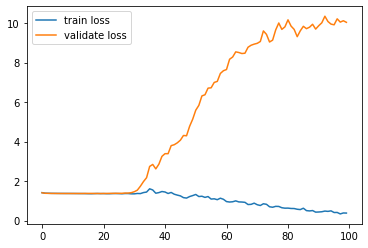

In [19]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

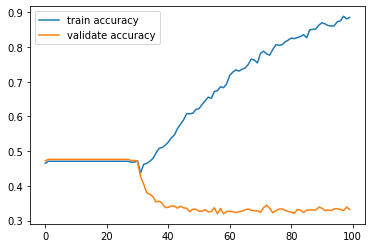

In [20]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()